# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [1]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [2]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.

Nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [3]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:


$$tsh \in(\,40, \,60\,)$$

$$(1) \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$

$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$

$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$

$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [4]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

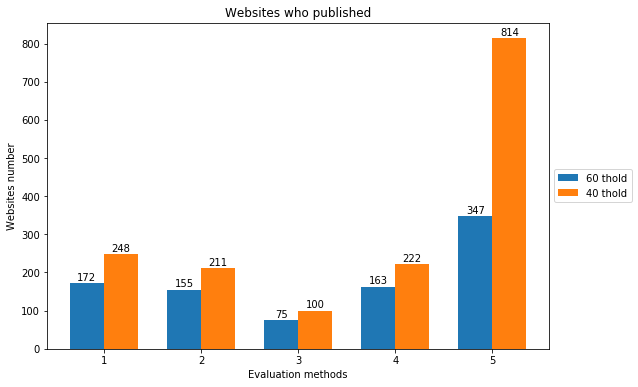

In [5]:
i = 0
generate_plot(i, stp)
plt.show()

### Percentuale siti con pubblicazioni

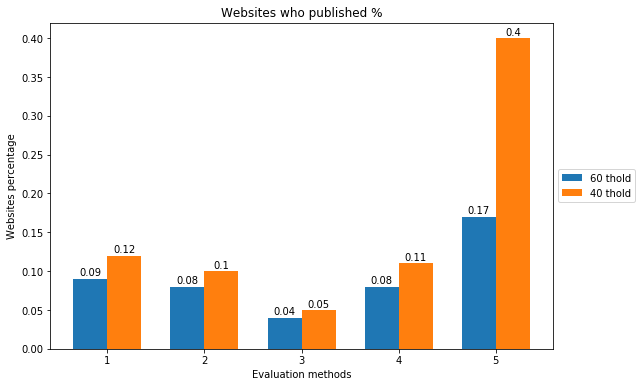

In [6]:
i = 1
generate_plot(i, stp)
plt.show()

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

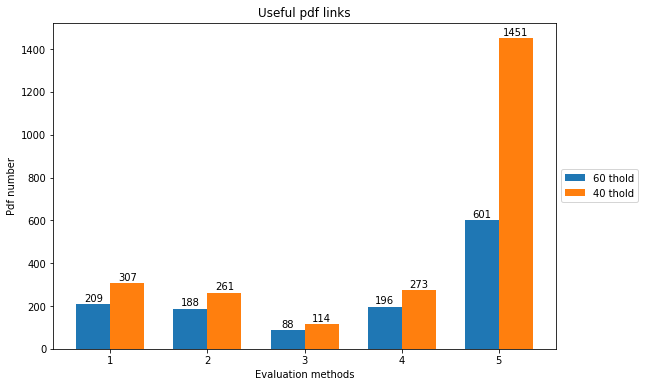

In [7]:
i = 2
generate_plot(i, stp)
plt.show()

### Percentuale di file pdf utili

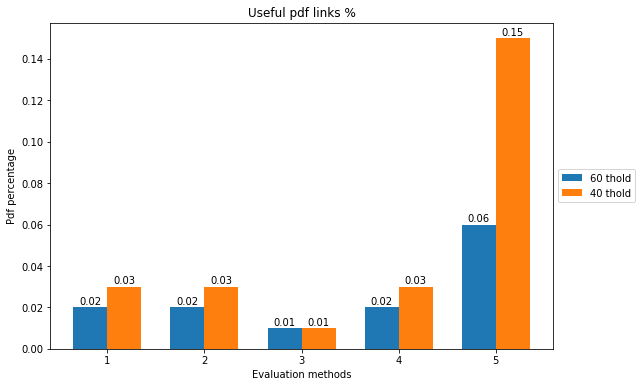

In [8]:
i = 3
generate_plot(i, stp)
plt.show()

### Profondità media dei file

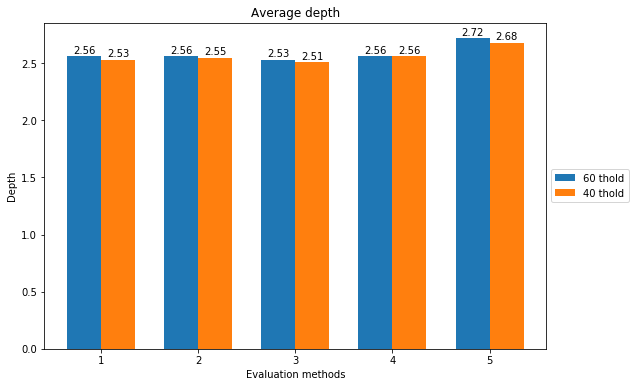

In [9]:
i = 4
generate_plot(i, stp)
plt.show()

### Numero di link presenti in homepage

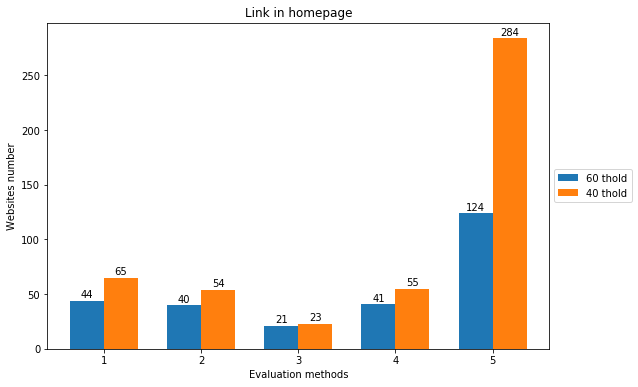

In [10]:
i = 5
generate_plot(i, stp)
plt.show()

# File processing

Dopo aver ottenuto la lista di link ( è stata utilizzata la lista ottenuta dalla prima condizione tra quelle testate, essendo quella che tiene in considerazione più file ) i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili.

In [11]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,307
1,file to process,239
2,file processed,218


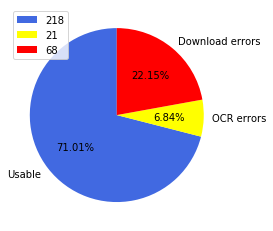

In [12]:
labels = 'Usable', 'OCR errors', 'Download errors'

val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'red']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

# Latent Dirichlet Allocation

In [1]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from lda_topic_model import preprocess
from sklearn.decomposition import LatentDirichletAllocation

dtm_tf, tf_vectorizer = preprocess("lda_topic_model/data/input.csv")
topics = 10
words = 10

lda = LatentDirichletAllocation(n_components = topics, random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.279097  0.274396       1        1  40.166888
4      0.308066  0.189000       2        1  34.652355
9      0.181158  0.028565       3        1   7.701376
7     -0.049803 -0.081389       4        1   3.168691
2     -0.079329 -0.036392       5        1   3.163468
3     -0.038057 -0.087356       6        1   2.623837
6     -0.014081 -0.074923       7        1   2.520775
1      0.019389 -0.074327       8        1   2.439139
8     -0.031984 -0.067930       9        1   2.158925
5     -0.016261 -0.069645      10        1   1.404547, topic_info=                    Term        Freq       Total Category  logprob  loglift
1130            economia  152.000000  152.000000  Default  30.0000  30.0000
495             business  197.000000  197.000000  Default  29.0000  29.0000
1140           economics  121.000000  121.000000  Default  28.0000  28.0000
1995              italia  102.000000  102.000000  Default  27.0000  27.0000
1029             diritto   80.000000   80.000000  Default  26.0000  26.0000
...                  ...         ...         ...      ...      ...      ...
2140         legislation    0.414427    3.078450  Topic10  -6.3989   2.2602
3008     promissory_note    0.414427    1.750716  Topic10  -6.3989   2.8246
769   composite_material    0.414427    1.496921  Topic10  -6.3989   2.9812
2661             organo_    0.414427    3.685096  Topic10  -6.3989   2.0803
2315         mathematics    0.414427    2.071944  Topic10  -6.3989   2.6561

[567 rows x 6 columns], token_table=      Topic      Freq                                              Term
term                                                                   
1         4  0.568601                                              1992
4         4  0.568601                                          2_rocket
13        4  0.568601                                                96
14        2  0.225927                                                9p
14        3  0.451854                                                9p
...     ...       ...                                               ...
4160      9  0.633689  wharton_school_of_the_university_of_pennsylvania
4178      6  0.910267                                        wirtschaft
4195      1  0.831702                                      working_time
4195      6  0.092411                                      working_time
4240      4  0.858545                                          économie

[738 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 10, 8, 3, 4, 7, 2, 9, 6])